In [1]:
# -- driver_run_forecast_LV1.py  --
# master python script to do a full LV1 forecast simulation

import sys
import pickle
import numpy as np
import os
from datetime import datetime, timedelta
import gc
import resource
import subprocess

##############

sys.path.append('../sdpm_py_util')

import atm_functions as atmfuns
import ocn_functions as ocnfuns
import grid_functions as grdfuns
import plotting_functions as pltfuns
from get_PFM_info import get_PFM_info
import init_funs as infuns
from make_LV1_dotin_and_SLURM import make_LV1_dotin_and_SLURM
from run_slurm_LV1 import run_slurm_LV1



/home/mspydell/models/PFM_root/PFM/driver/../sdpm_py_util/ocn_functions.py:25: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


In [2]:

print('\nStarting the LV1 simulation, Current time ', datetime.now())

# we are going to make a forecast
run_type = 'forecast'

# PFM has all of the information needed to run the model
clean_start = True
infuns.initialize_simulation(clean_start)




Starting the LV1 simulation, Current time  2024-09-27 15:02:54.204572
we are going to start clean...
getting PFM info...
removing PFM info file...
now removing all input files...
now making a new PFM.pkl file.
we are not adding tidal forcing as Hycom includes tides.
PFM info was saved as /scratch/PFM_Simulations/PFM_run_info.pkl


In [ ]:

PFM=get_PFM_info()

# return the hycom forecast date based on the PFM simulation times
#yyyymmdd_hy = infuns.determine_hycom_foretime() 

t1  = PFM['fetch_time']                              # this is the first time of the PFM forecast
# now a string of the time to start ROMS (and the 1st atm time too)
yyyymmddhhmm_pfm = "%d%02d%02d%02d%02d" % (t1.year, t1.month, t1.day, t1.hour, t1.minute)
t2  = t1 + PFM['forecast_days'] * timedelta(days=1)  # this is the last time of the PFM forecast

t1str = "%d%02d%02d%02d%02d" % (t1.year, t1.month, t1.day, t1.hour, t1.minute)
t2str = "%d%02d%02d%02d%02d" % (t2.year, t2.month, t2.day, t2.hour, t2.minute)



print('going to do a PFM forecast from')
print(t1)
print('to')
print(t2)
print('\n')

# get_hycom_foretime is a function that returns the lates hycom forecast date with data to span the PFM forecast from 
# this functions cleans, then refreshes the hycom directory.
yyyymmdd_hy = ocnfuns.get_hycom_foretime(t1str,t2str)


# now make the catted hycom data .nc file
#ocnfuns.cat_hycom_to_onenc(yyyymmdd_hy,[t1,t2])
print('we will use the hycom forecast from')
print(yyyymmdd_hy)
print('for the PFM forecast.\n')


In [4]:
print(yyyymmdd_hy)
print(t1str)
print(t2str)
print('catting the hycom.nc files into one...')
#ocnfuns.cat_hycom_to_onenc(yyyymmdd_hy,t1str,t2str)

ocnfuns.cat_hycom_to_twonc_1hr(yyyymmdd_hy,t1str,t2str)
print('...done.\n')

ocnfuns.hycom_cats_to_pickle(yyyymmdd_hy) # this is the one for 1 hr zeta


20240924
202409261200
202409290000
catting the hycom.nc files into one...
writing to .nc ...
...done.



In [5]:

print('making the hycom pickle files from catted hycom.nc...')
ocnfuns.hycom_cat_to_pickles(yyyymmdd_hy)
print('...done.\n')


use_ncks = 1 # flag to get data using ncks. if =0, then a pre saved pickle file is loaded.
use_pckl_sav = 1
sv_ocnR_pkl_file=1
fr_ocnR_pkl_file=1
frm_ICpkl_file = 1
frm_BCpkl_file = 1
fr_ocnR_pkl_file=1

# what are we going to plot?
plot_ocn = 1
plot_ocnr = 1
plot_atm = 1
plot_all_atm = 1
plot_ocn_icnc= 1
load_plot_atm= 1

# need the file names and locations of the pickle and .nc files we will save
fn_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocn_tmp_pckl_file']
ocnIC_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocnIC_tmp_pckl_file']
ic_file_out = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ini_file']
bc_file_out = PFM['lv1_forc_dir'] + '/' + PFM['lv1_bc_file']
ocnBC_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocnBC_tmp_pckl_file']
fn_atm_out = PFM['lv1_forc_dir'] + '/' + PFM['lv1_atm_file'] # LV1 atm forcing filename


t0 = datetime.now()

if plot_ocn ==1:
    print('making some plots from: ' + fn_pckl)
    cmd_list = ['python','-W','ignore','plotting_functions.py','plot_ocn_fields_from_dict_pckl',fn_pckl]
    os.chdir('../sdpm_py_util')
    ret1 = subprocess.run(cmd_list)     
    #pltfuns.plot_ocn_fields_from_dict_pckl(fn_pckl)
    print('subprocess return code? ' + str(ret1.returncode) +  ' (0=good)')
    print('...done')
    os.chdir('../driver')

t1= datetime.now()
print('this took:')
print(t1-t0)
print('\n')




# put the ocn data on the roms grid
print('starting: ocnfuns.hycom_to_roms_latlon(OCN,RMG)')
if sv_ocnR_pkl_file==0:
    print('returning OCN_R')
    OCN_R  = ocnfuns.hycom_to_roms_latlon(OCN,RMG)
else:
    os.chdir('../sdpm_py_util')
    print('putting the hycom data in ' + fn_pckl + ' on the roms grid...')
    cmd_list = ['python','-W','ignore','ocn_functions.py','make_all_tmp_pckl_ocnR_files',fn_pckl]
    os.chdir('../sdpm_py_util')
    ret1 = subprocess.run(cmd_list)     
    #ocnfuns.make_all_tmp_pckl_ocnR_files(fn_pckl)
    os.chdir('../driver')
    print('subprocess return code? ' + str(ret1.returncode) +  ' (0=good)')


cmd_list = ['python','-W','ignore','ocn_functions.py','print_maxmin_HYrm_pickles']
os.chdir('../sdpm_py_util')
ret1 = subprocess.run(cmd_list)     
os.chdir('../driver')
#ocnfuns.print_maxmin_HYrm_pickles()
print('driver_run_forecast_LV1: done with hycom_to_roms_latlon')
# add OCN + OCN_R plotting function here !!!

## plot OCN_R
if plot_ocnr == 1:
#    pltfuns.plot_ocn_R_fields_pckl()
    print('plotting LV1 ocn_R_fields...')
    cmd_list = ['python','-W','ignore','plotting_functions.py','plot_ocn_R_fields_pckl']
    os.chdir('../sdpm_py_util')
    ret1 = subprocess.run(cmd_list)     
    os.chdir('../driver')
    print('subprocess return code? ' + str(ret1.returncode) +  ' (0=good)')

t2 = datetime.now()
print('...done with LV1 ocn_R')
print('this took:')
print(t2-t1)
print('\n')



# make the depth pickle file
print('making the depth pickle file...')
fname_depths = PFM['lv1_forc_dir'] + '/' + PFM['lv1_depth_file']
cmd_list = ['python','-W','ignore','ocn_functions.py','make_rom_depths',fname_depths]
os.chdir('../sdpm_py_util')
ret6 = subprocess.run(cmd_list)     
os.chdir('../driver')
print('subprocess return code? ' + str(ret6.returncode) +  ' (0=good)')
print('\n')


if fr_ocnR_pkl_file==0:
    OCN_IC = ocnfuns.ocn_r_2_ICdict(OCN_R,RMG,PFM)
else:
    print('going to save OCN_IC to a pickle file: ' + ocnIC_pckl)
    os.chdir('../sdpm_py_util')
    cmd_list = ['python','-W','ignore','ocn_functions.py','ocn_r_2_ICdict_pckl',ocnIC_pckl]
    ret3 = subprocess.run(cmd_list)     
    os.chdir('../driver')
    print('OCN IC data saved with pickle, correctly? ' + str(ret3.returncode) + ' (0=yes,1=no)')

print('driver_run_forecast_LV1: done with ocn_r_2_ICdict')
# add OCN_IC.nc plotting function here !!!!
t4 = datetime.now()
print('this took:')
print(t4-t2)
print('\n')



if frm_ICpkl_file == 0:
    print('making IC file: '+ ic_file_out)
    ocnfuns.ocn_roms_IC_dict_to_netcdf(OCN_IC, ic_file_out)
else:
    print('making IC file from pickled IC: '+ ic_file_out)
    cmd_list = ['python','-W','ignore','ocn_functions.py','ocn_roms_IC_dict_to_netcdf_pckl',ocnIC_pckl,ic_file_out]
    os.chdir('../sdpm_py_util')
    ret4 = subprocess.run(cmd_list)     
    os.chdir('../driver')
    print('OCN IC nc data saved, correctly? ' + str(ret4.returncode) + ' (0=yes)')

print('done makeing IC file.')

if plot_ocn_icnc == 1:
    pltfuns.plot_ocn_ic_fields(ic_file_out)

t5 = datetime.now()
print('this took:')
print(t5-t4)
print('\n')



# get the OCN_BC dictionary
if fr_ocnR_pkl_file==0:
    OCN_BC = ocnfuns.ocn_r_2_BCdict(OCN_R,RMG,PFM)
else:
    print('going to save OCN_BC to a pickle file to:')
    ocnBC_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocnBC_tmp_pckl_file']
    print(ocnBC_pckl) 
    os.chdir('../sdpm_py_util')
    cmd_list = ['python','-W','ignore','ocn_functions.py','ocn_r_2_BCdict_pckl_new',ocnBC_pckl]
    ret4 = subprocess.run(cmd_list)     
    os.chdir('../driver')
    print('OCN BC data saved with pickle, correctly? ' + str(ret4.returncode) + ' (0=yes)')
    
t6 = datetime.now()
print('this took:')
print(t6-t5)
print('\n')


if frm_BCpkl_file == 0:
    print('making BC file: '+ bc_file_out)
    ocnfuns.ocn_roms_BC_dict_to_netcdf(OCN_BC, bc_file_out)
else:
    print('making BC nc file from pickled BC: '+ bc_file_out)
    cmd_list = ['python','-W','ignore','ocn_functions.py','ocn_roms_BC_dict_to_netcdf_pckl',ocnBC_pckl,bc_file_out]
    os.chdir('../sdpm_py_util')
    ret5 = subprocess.run(cmd_list)     
    os.chdir('../driver')
    print('OCN BC nc data saved, correctly? ' + str(ret5.returncode) + ' (0=yes)')

print('done makeing BC nc file.')
t7 = datetime.now()
print('this took:')
print(t7-t6)
print('\n')


# now for the atm part...
cmd_list = ['python','-W','ignore','atm_functions.py','get_atm_data_as_dict']
os.chdir('../sdpm_py_util')
ret5 = subprocess.run(cmd_list)   
print('return code: ' + str(ret5.returncode) + ' (0=good)')  
os.chdir('../sdpm_py_util')
print('...done.')
t8 = datetime.now()
print('this took:')
print(t8-t7)
print('\n')

# plot some stuff
if plot_atm == 1:
    pltfuns.plot_atm_fields()
    print('done with plotting ATM fields')

t9 = datetime.now()
print('this took:')
print(t9-t8)
print('\n')

level = 1
# put the atm data on the roms grid, and rotate the velocities
# everything in this dict turn into the atm.nc file
print('in atmfuns.get_atm_data_on_roms_grid(ATM,RMG)')
#ATM_R  = atmfuns.get_atm_data_on_roms_grid(ATM,RMG)
cmd_list = ['python','-W','ignore','atm_functions.py','get_atm_data_on_roms_grid',str(level)]
os.chdir('../sdpm_py_util')
ret5 = subprocess.run(cmd_list)   
print('return code: ' + str(ret5.returncode) + ' (0=good)')  
os.chdir('../sdpm_py_util')
print('done with: atmfuns.get_atm_data_on_roms_grid(ATM,RMG)')
# all the fields plotted with the data on roms grid

if plot_all_atm == 1:
#    pltfuns.plot_all_fields_in_one(ATM, ATM_R, RMG, PFM)
    pltfuns.plot_all_fields_in_one(str(level))
    print('done with: pltfuns.plot_all_fields_in_one(ATM, ATM_R, RMG, PFM)')

t10 = datetime.now()
print('this took:')
print(t10-t9)
print('\n')

# fn_out is the name of the atm.nc file used by roms
print('driver_run_forcast_LV1: saving ATM file to ' + fn_atm_out)
#atmfuns.atm_roms_dict_to_netcdf(ATM_R,fn_atm_out)
cmd_list = ['python','-W','ignore','atm_functions.py','atm_roms_dict_to_netcdf',str(level)]
os.chdir('../sdpm_py_util')
ret5 = subprocess.run(cmd_list)   
print('return code: ' + str(ret5.returncode) + ' (0=good)')  
os.chdir('../sdpm_py_util')
print('driver_run_forecast_LV1:  done with writing ATM.nc file.') 
# put in a function to plot the atm.nc file if we want to

if load_plot_atm == 1:
    pltfuns.load_and_plot_atm(str(level))
    print('done with pltfuns.load_and_plot_atm(PFM)')

t11 = datetime.now()
print('this took:')
print(t11-t10)
print('\n')


print('driver_run_forecast_LV1:  now make .in and .sb files')

pfm_driver_src_dir = os.getcwd()

yyyymmdd = PFM['yyyymmdd']
hhmm = PFM['hhmm']



making the hycom pickle files from catted hycom.nc...

max and min raw hycom data (iz is top [0] to bottom [39]):
max zeta   =  0.941 m          at  ( it, ilat, ilon)     =  (  4,  50,  99)
min zeta   = -1.026 m          at  ( it, ilat, ilon)     =  (  7, 148,  56)
max u      =  0.490 m/s        at  ( it, iz, ilat, ilon) =  (  3,  0,  74,  53)
min u      = -0.527 m/s        at  ( it, iz, ilat, ilon) =  (  8,  2, 187,   0)
max v      =  0.437 m/s        at  ( it, iz, ilat, ilon) =  (  0,  4, 200,  22)
min v      = -0.613 m/s        at  ( it, iz, ilat, ilon) =  ( 11,  0,  49,  83)
max temp   = 23.637 C          at  ( it, iz, ilat, ilon) =  (  4,  0,   4,   0)
min temp   =  1.360 C          at  ( it, iz, ilat, ilon) =  ( 19, 38,  49,  12)
max dT/dz  =  1.794 C/m        at  ( it, iz, ilat, ilon) =  (  1,  1,  84,  89)
min dT/dz  = -0.159 C/m        at  ( it, iz, ilat, ilon) =  ( 13, 13, 121,  56)
max salt   = 34.714 psu        at  ( it, iz, ilat, ilon) =  (  0, 37,  48,  79)
min salt   = 3

<Figure size 640x480 with 0 Axes>

In [6]:
print(PFM['lv1_tides_file'])

ocean_tide.nc


 --- making dot_in and dot_sb --- 
...done
now running roms with slurm
run_slurm_LV1: current directory is now:  /scratch/PFM_Simulations/LV1_Forecast/Run
CompletedProcess(args=['sbatch', '--wait', 'LV1_SLURM.sb'], returncode=0, stdout=b'Submitted batch job 466\n', stderr=b'')
subprocess slurm ran correctly? 0 (0=yes)
run_slurm_LV1: run command:  ['sbatch', '--wait', 'LV1_SLURM.sb']
this took:
0:08:46.265500



Finished the LV1 simulation
now making LV1 history file plots
Current time:  2024-09-26 11:31:29.058806


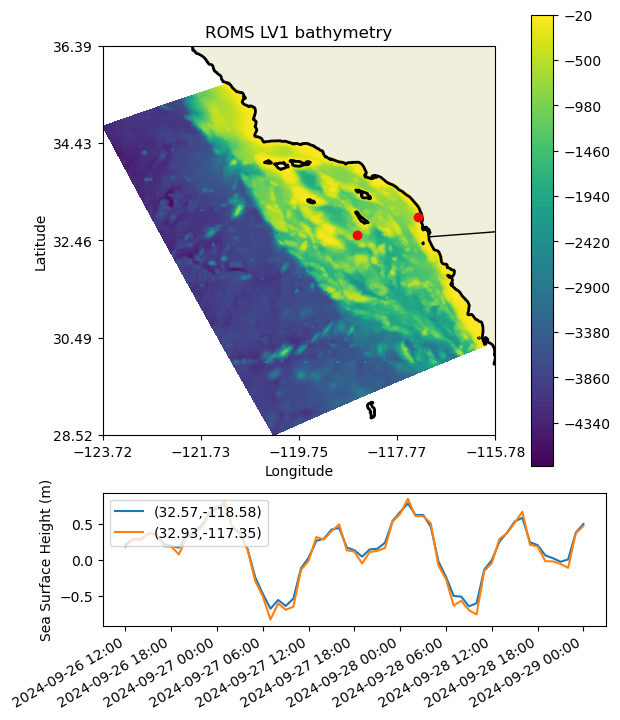

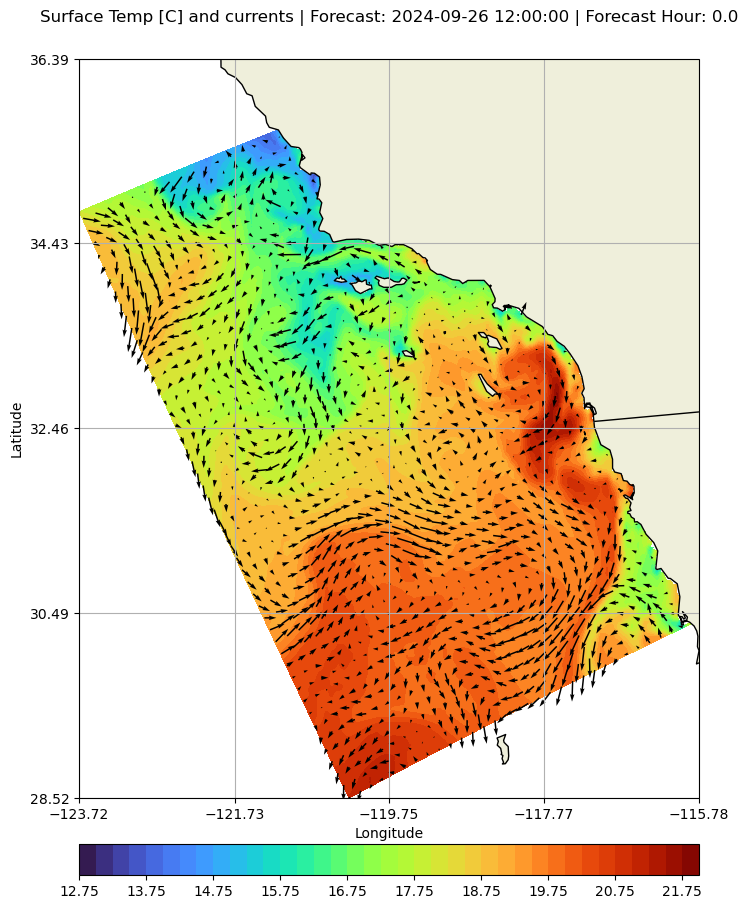

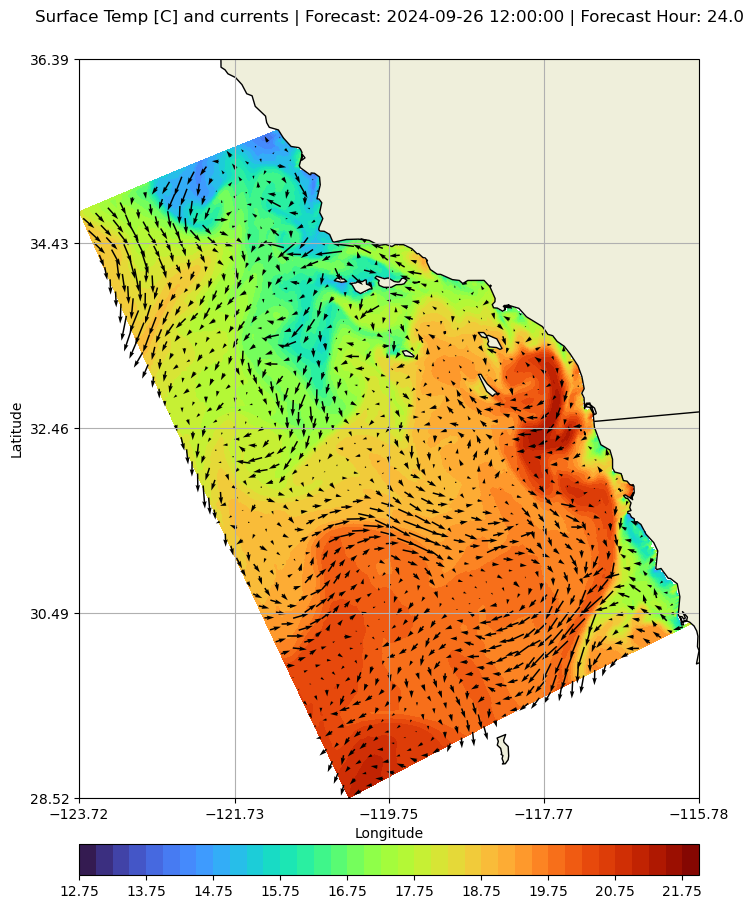

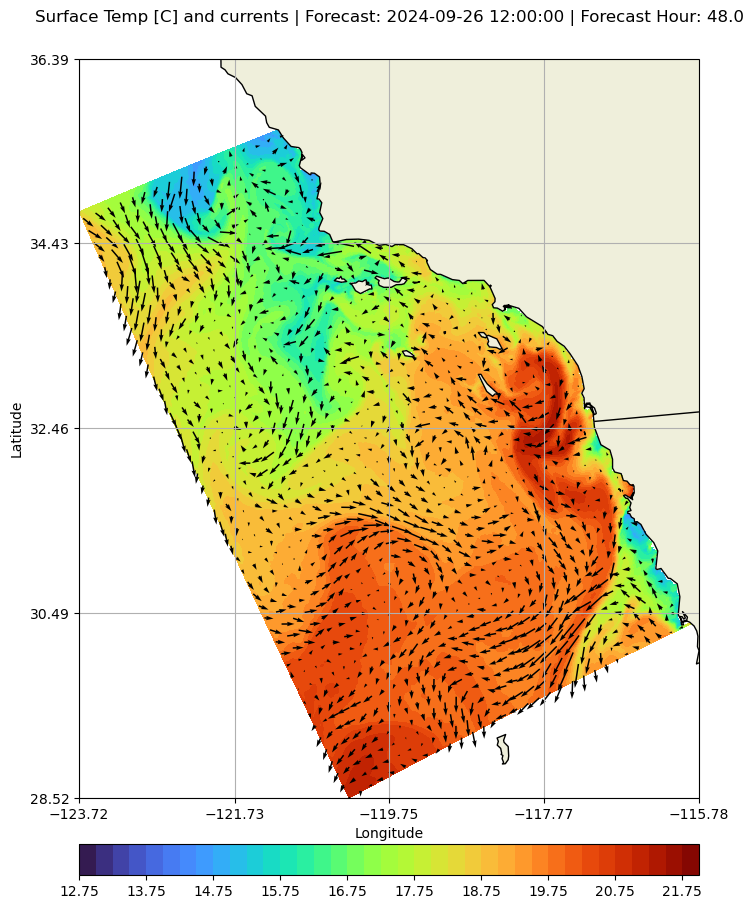

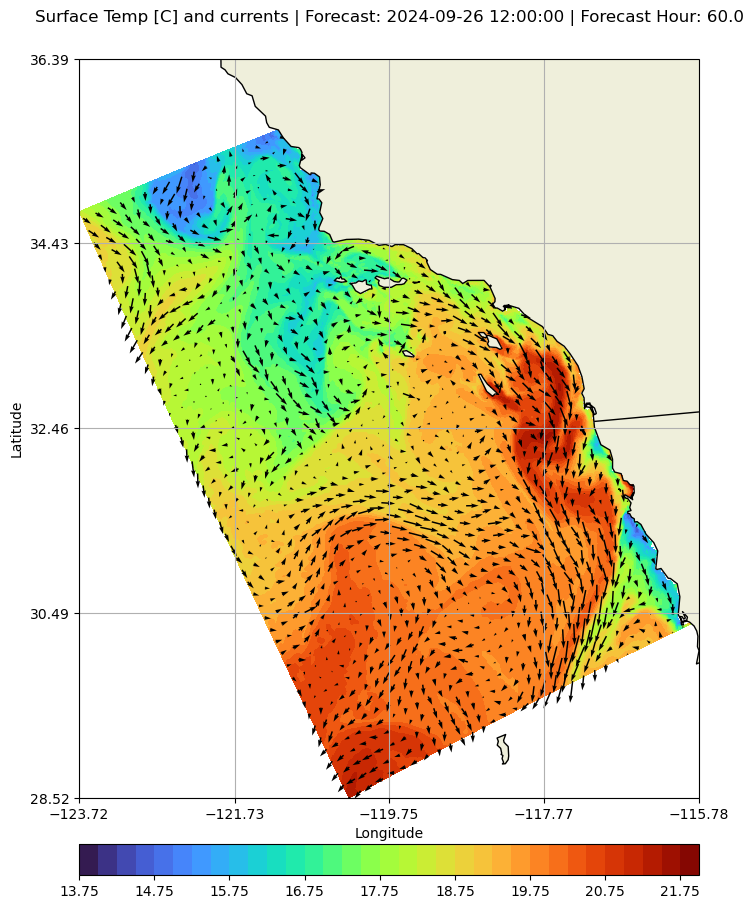

In [8]:

os.chdir('../sdpm_py_util')
make_LV1_dotin_and_SLURM( PFM , yyyymmdd + hhmm )
print('...done')

# run command will be
print('now running roms with slurm')
run_slurm_LV1(PFM)

os.chdir('../driver')

t12 = datetime.now()
print('this took:')
print(t12-t11)
print('\n')

# now making history file plots
print('\nFinished the LV1 simulation')
print('now making LV1 history file plots')
pltfuns.make_all_his_figures('LV1')
print('Current time: ', datetime.now())

#######################




In [12]:

fnames = ocnfuns.get_hycom_nc_file_names(yyyymmdd,t1str,t2str)


20240923
1200


In [ ]:


fetch_time = PFM['fetch_time'] # the start of the PFM forecast
hy_time = datetime(fetch_time.year,fetch_time.month,fetch_time.day)
hy_time = hy_time - timedelta(days=1)
yyyymmdd = "%d%02d%02d" % (hy_time.year, hy_time.month, hy_time.day)

print(PFM['forecast_days'])

t1  = fetch_time                                     # this is the first time of the PFM forecast
t2  = t1 + PFM['forecast_days'] * timedelta(days=1)  # this is the last time of the PFM forecast

print('making a PFM simulation starting from')
print(t1)
print('and ending at')
print(t2)
print('getting the right hycom data...')
# make stuff below this into a function...
# n0 is the number of files we should have
# num_missing is the number of files we are missing
n0, num_missing = ocnfuns.check_hycom_data(yyyymmdd,[t1,t2])
print('there should be ' + str(n0) + ' files.')
print('there are ' + str(num_missing) + ' missing files.')



In [ ]:


if num_missing == 0:
    print('we have the hycom files from the ' + yyyymmdd )
    print('hycom forecast to run the PFM forecast')
    ocnfuns.cat_hycom_to_onenc(yyyymmdd,[t1,t2])
    # cat hycom files to one .nc.
else:
    # try downloading all of the data again
    print('we did not have the files from the ' + yyyymmdd + ' hycom forecast')
    print('but we will try getting that data again. Maybe hycom filled in their .nc files?')
    ocnfuns.get_hycom_data(yyyymmdd)
    n02, num_missing2 = ocnfuns.check_hycom_data(yyyymmdd,[t1,t2])
    if num_missing2 == 0:
        print('Hycom now has the data we need to run the PFM forecast')
        print('catting the hycom.nc files into one...')
        ocnfuns.cat_hycom_to_onenc(yyyymmdd,[t1,t2])
        print('...done')
    else:
        print('we need the change the date of the hycom forecast (but not change the dates of the PFM forecast)')
        # yyyymmdd = yyyymmdd - 1 day
        # do this over again!



In [3]:
ocnfuns.cat_hycom_to_onenc(yyyymmdd,[t1,t2])


In [1]:
import sys
sys.path.append('../sdpm_py_util')
import ocn_functions as ocnfuns
t0str = '20240925'
t1str = '202409251200'
t2str = '202409301200'
ncfns = ocnfuns.get_hycom_nc_file_names(t0str,t1str,t2str)

print(ncfns[0])
print(ncfns[0][-19:-3])
print(ncfns[0][-41:-37])


/scratch/PFM_Simulations/hycom_data/hy_s3z_2024-09-25T12:00_2024-09-25T12:00.nc
2024-09-25T12:00
_s3z


/home/mspydell/models/PFM_root/PFM/driver/../sdpm_py_util/ocn_functions.py:25: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


In [ ]:
import sys
sys.path.append('../sdpm_py_util')
import ocn_functions as ocnfuns
yyyymmdd = '20240929'
ocnfuns.get_hycom_data_1hr(yyyymmdd)


In [ ]:
import sys
sys.path.append('../sdpm_py_util')
import ocn_functions as ocnfuns
from datetime import datetime, timedelta

dtlist=ocnfuns.stored_hycom_dates()
print(dtlist)
yyyymmdd='20240929'
t1 = datetime(2024,9,29,12,0,0)
t2 = t1 + timedelta(days=8)

nfile,nmiss = ocnfuns.check_hycom_data(yyyymmdd,[t1,t2])
print(nfile)
print(nmiss)

t1str = '202409291200'
t2str = '202410010000'
hytime=ocnfuns.get_hycom_foretime(t1str,t2str)

ocnfuns.cat_hycom_to_twonc_1hr(hytime,t1str,t2str)

In [3]:
import sys
import os
import subprocess
sys.path.append('../sdpm_py_util')
import ocn_functions as ocnfuns
from get_PFM_info import get_PFM_info

PFM=get_PFM_info()
yyyymmdd = '20240925'
t1str    = '202409271800'
t2str    = '202409301600'

#ocnfuns.get_hycom_data_1hr(yyyymmdd)
ocnfuns.cat_hycom_to_twonc_1hr(yyyymmdd,t1str,t2str)
ocnfuns.hycom_cats_to_pickle(yyyymmdd) # this is the one for 1 hr zeta

os.chdir('../sdpm_py_util')
fn_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocn_tmp_pckl_file']
cmd_list = ['python','-W','ignore','ocn_functions.py','make_all_tmp_pckl_ocnR_files_1hrzeta',fn_pckl]
ret1 = subprocess.run(cmd_list)     
os.chdir('../sdpm_py_util')



writing to .nc ...
writing to .nc ...

max and min raw hycom data (iz is top [0] to bottom [39]):
max zeta   =  1.126 m          at  ( it, ilat, ilon)     =  ( 57, 167,  40)
min zeta   = -0.928 m          at  ( it, ilat, ilon)     =  ( 64, 167,  40)
max u      =  0.490 m/s        at  ( it, iz, ilat, ilon) =  (  1,  0,  74,  53)
min u      = -0.483 m/s        at  ( it, iz, ilat, ilon) =  ( 15,  2, 149,  45)
max v      =  0.468 m/s        at  ( it, iz, ilat, ilon) =  (  2, 12, 197,  23)
min v      = -0.632 m/s        at  ( it, iz, ilat, ilon) =  (  5,  0,  18, 102)
max temp   = 22.584 C          at  ( it, iz, ilat, ilon) =  (  2,  0,   0,   3)
min temp   =  1.355 C          at  ( it, iz, ilat, ilon) =  (  3, 38,  58,  32)
max dT/dz  =  1.739 C/m        at  ( it, iz, ilat, ilon) =  (  3,  1,  84,  89)
min dT/dz  = -0.169 C/m        at  ( it, iz, ilat, ilon) =  (  3, 13, 121,  56)
max salt   = 34.717 psu        at  ( it, iz, ilat, ilon) =  (  9, 38,  58,  32)
min salt   = 32.892 psu       

In [1]:
import sys
import os
import subprocess
sys.path.append('../sdpm_py_util')
import ocn_functions as ocnfuns
from get_PFM_info import get_PFM_info

PFM=get_PFM_info()


fname_depths = PFM['lv1_forc_dir'] + '/' + PFM['lv1_depth_file']
cmd_list = ['python','-W','ignore','ocn_functions.py','make_rom_depths_1hrzeta',fname_depths]
os.chdir('../sdpm_py_util')
ret6 = subprocess.run(cmd_list)     
os.chdir('../driver')


/home/mspydell/models/PFM_root/PFM/driver/../sdpm_py_util/ocn_functions.py:25: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


depth pickle file /scratch/PFM_Simulations/LV1_Forecast/Forc/roms_tmp_depth_file.pklalready exists.


In [4]:

ic_file_out = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ini_file']
bc_file_out = PFM['lv1_forc_dir'] + '/' + PFM['lv1_bc_file']

ocnIC_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocnIC_tmp_pckl_file']
os.chdir('../sdpm_py_util')
cmd_list = ['python','-W','ignore','ocn_functions.py','ocn_r_2_ICdict_pckl',ocnIC_pckl]
ret3 = subprocess.run(cmd_list)     
os.chdir('../driver')

cmd_list = ['python','-W','ignore','ocn_functions.py','ocn_roms_IC_dict_to_netcdf_pckl',ocnIC_pckl,ic_file_out]
os.chdir('../sdpm_py_util')
ret4 = subprocess.run(cmd_list)     
os.chdir('../driver')


ocnBC_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocnBC_tmp_pckl_file']
os.chdir('../sdpm_py_util')
cmd_list = ['python','-W','ignore','ocn_functions.py','ocn_r_2_BCdict_pckl_new_1hrzeta',ocnBC_pckl]
ret4 = subprocess.run(cmd_list)     
os.chdir('../driver')

cmd_list = ['python','-W','ignore','ocn_functions.py','ocn_roms_BC_dict_to_netcdf_pckl_1hrzeta',ocnBC_pckl,bc_file_out]
os.chdir('../sdpm_py_util')
ret5 = subprocess.run(cmd_list)     
os.chdir('../driver')



OCN_IC dict saved with pickle
OCN_IC dict loaded with pickle

max and min of data in ROMS IC file (iz is bottom [0] to top [39], note: it is always 0 b/c IC):
max zeta   =  0.401 m          at  ( it, ilat, ilon)     =  (  0, 329,   0)
min zeta   = -0.086 m          at  ( it, ilat, ilon)     =  (  0,  92, 245)
max ubar   =  0.146 m/s        at  ( it, ilat, ilon)     =  (  0, 172, 201)
min ubar   = -0.169 m/s        at  ( it, ilat, ilon)     =  (  0,  41, 190)
max vbar   =  0.189 m/s        at  ( it, ilat, ilon)     =  (  0,  18, 226)
min vbar   = -0.158 m/s        at  ( it, ilat, ilon)     =  (  0, 161, 215)
max u      =  0.380 m/s        at  ( it, iz, ilat, ilon) =  (  0, 39, 139,  90)
min u      = -0.386 m/s        at  ( it, iz, ilat, ilon) =  (  0, 38, 302,   0)
max v      =  0.460 m/s        at  ( it, iz, ilat, ilon) =  (  0, 29, 328, 107)
min v      = -0.410 m/s        at  ( it, iz, ilat, ilon) =  (  0, 39, 356,  53)
max temp   = 21.003 C          at  ( it, iz, ilat, ilon) =  (  0,

In [4]:
# now for the atm part...
print('we are now getting the atm data and saving as a dict...')
t01 = datetime.now()
cmd_list = ['python','-W','ignore','atm_functions.py','get_atm_data_as_dict']
os.chdir('../sdpm_py_util')
ret5 = subprocess.run(cmd_list)   
print('return code: ' + str(ret5.returncode) + ' (0=good)')  
os.chdir('../sdpm_py_util')
print('...done.')
t02 = datetime.now()
print('this took:')
print(t02-t01)
print('\n')


we are now getting the atm data and saving as a dict...

ATM dict saved with pickle.
return code: 0 (0=good)
...done.
this took:
0:00:39.756196




NameError: name 'plot_atm' is not defined

In [5]:

plot_atm = 1
# plot some stuff
if plot_atm == 1:
    print('we are now plotting the atm data...')
    t01 = datetime.now()
    pltfuns.plot_atm_fields()
    print('...done with plotting ATM fields')

t02 = datetime.now()
print('this took:')
print(t02-t01)
print('\n')

level = 1
# put the atm data on the roms grid, and rotate the velocities
# everything in this dict turn into the atm.nc file
print('we are now putting the atm data on the roms LV1 grid...')
t01 = datetime.now()
cmd_list = ['python','-W','ignore','atm_functions.py','get_atm_data_on_roms_grid',str(level)]
os.chdir('../sdpm_py_util')
ret5 = subprocess.run(cmd_list)   
print('return code: ' + str(ret5.returncode) + ' (0=good)')  
os.chdir('../sdpm_py_util')
print('...done.')
# all the fields plotted with the data on roms grid
t02 = datetime.now()
print('this took:')
print(t02-t01)
print('\n')


we are now plotting the atm data...
...done with plotting ATM fields
this took:
0:00:05.808495


we are now putting the atm data on the roms LV1 grid...

ATM on roms grid dict saved with pickle.
return code: 0 (0=good)
...done.
this took:
0:00:01.743538




NameError: name 'plot_all_atm' is not defined

In [6]:

plot_all_atm = 1
if plot_all_atm == 1:
    t01 = datetime.now()
    print('we are now plotting the atm data on roms grid...')
    pltfuns.plot_all_fields_in_one(str(level))
    print('...done.')

t02 = datetime.now()
print('this took:')
print(t02-t01)
print('\n')


we are now plotting the atm data on roms grid...
...done.
this took:
0:00:10.184117




NameError: name 'fn_atm_out' is not defined

<Figure size 640x480 with 0 Axes>

In [7]:


fn_atm_out = PFM['lv1_forc_dir'] + '/' + PFM['lv1_atm_file'] # LV1 atm forcing filename
# fn_out is the name of the atm.nc file used by roms
print('we are now saving ATM LV1 to ' + fn_atm_out + ' ...')
t01 = datetime.now()
cmd_list = ['python','-W','ignore','atm_functions.py','atm_roms_dict_to_netcdf',str(level)]
os.chdir('../sdpm_py_util')
ret5 = subprocess.run(cmd_list)   
print('return code: ' + str(ret5.returncode) + ' (0=good)')  
os.chdir('../sdpm_py_util')
print('...done.') 
# put in a function to plot the atm.nc file if we want to
t02 = datetime.now()
print('this took:')
print(t02-t01)
print('\n')


we are now saving ATM LV1 to /scratch/PFM_Simulations/LV1_Forecast/Forc/LV1_ATM_FORCING.nc ...
file_out is:
/scratch/PFM_Simulations/LV1_Forecast/Forc/LV1_ATM_FORCING.nc
return code: 0 (0=good)
...done.
this took:
0:00:00.997618




driver_run_forecast_LV1:  now make .in and .sb files...
 --- making dot_in and dot_sb --- 
...done.

now running roms with slurm...
run_slurm_LV1: current directory is now:  /scratch/PFM_Simulations/LV1_Forecast/Run
CompletedProcess(args=['sbatch', '--wait', 'LV1_SLURM.sb'], returncode=0, stdout=b'Submitted batch job 471\n', stderr=b'')
subprocess slurm ran correctly? 0 (0=yes)
run_slurm_LV1: run command:  ['sbatch', '--wait', 'LV1_SLURM.sb']
...done.
this took:
0:06:02.028460


now making LV1 history file plots...
...done.
this took:
0:00:08.268136




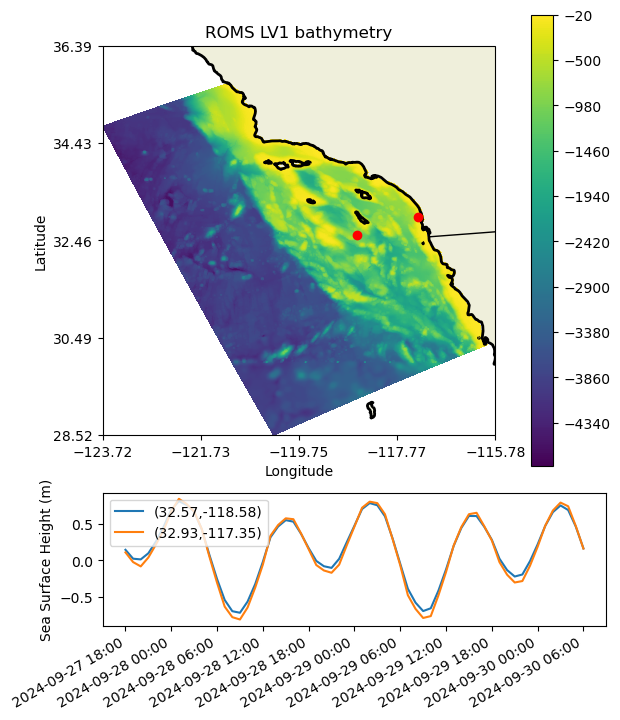

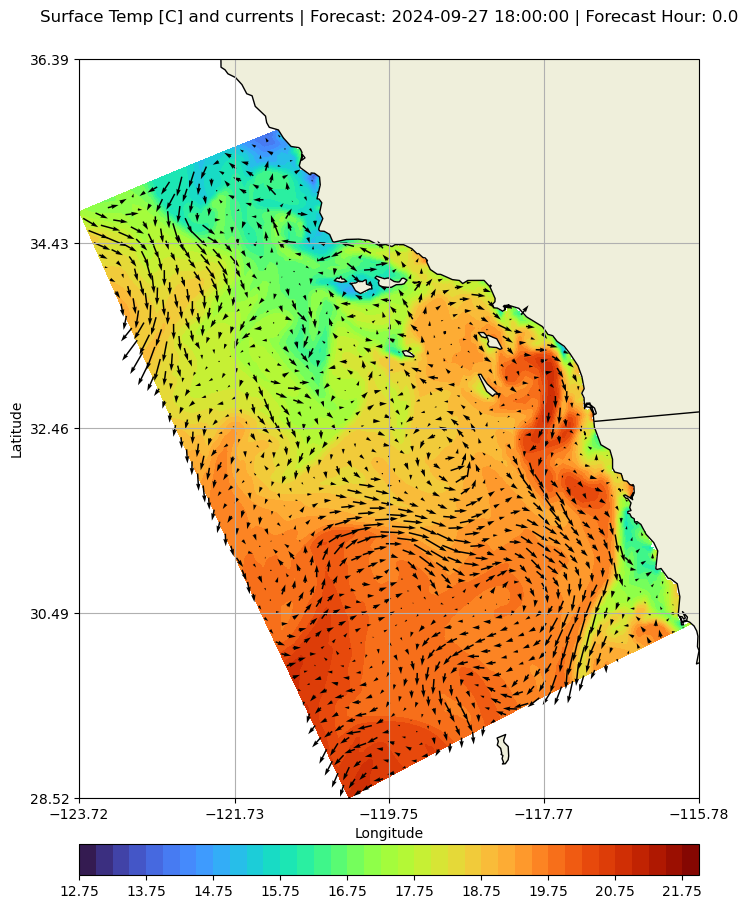

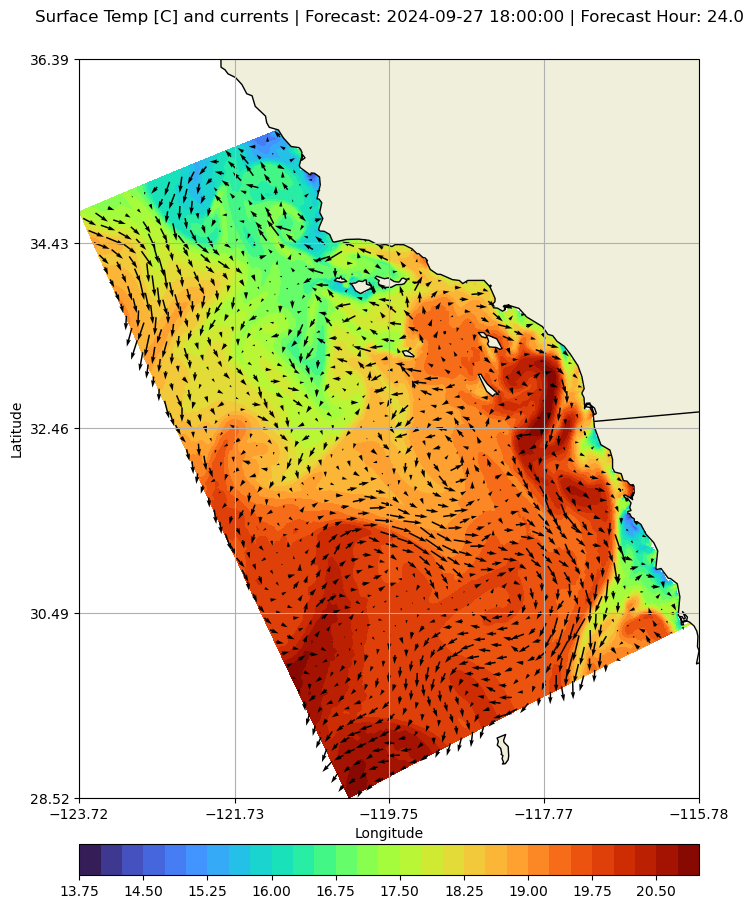

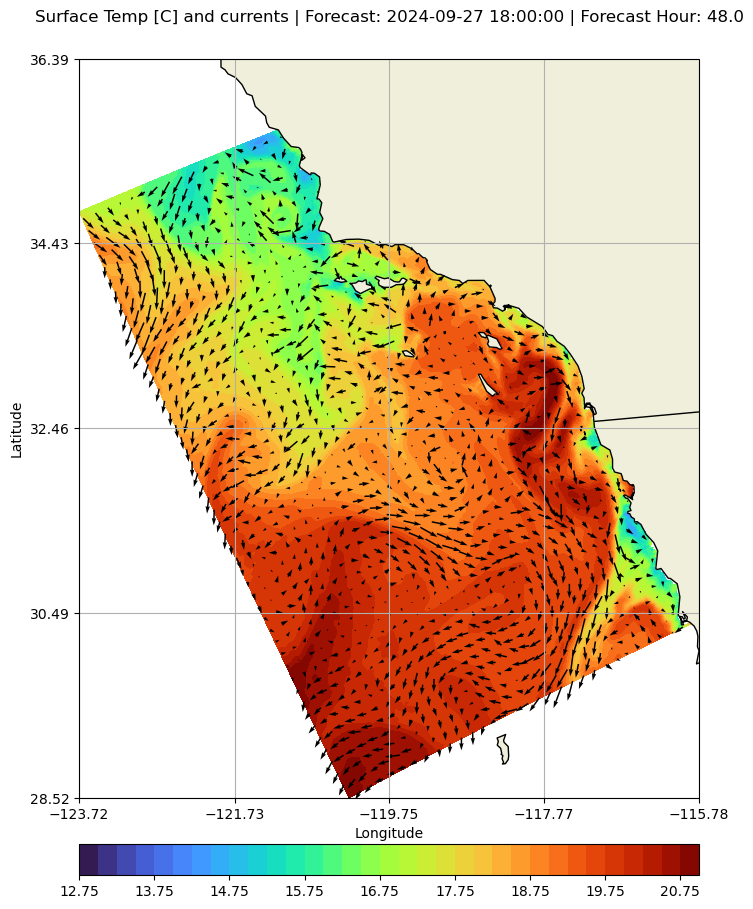

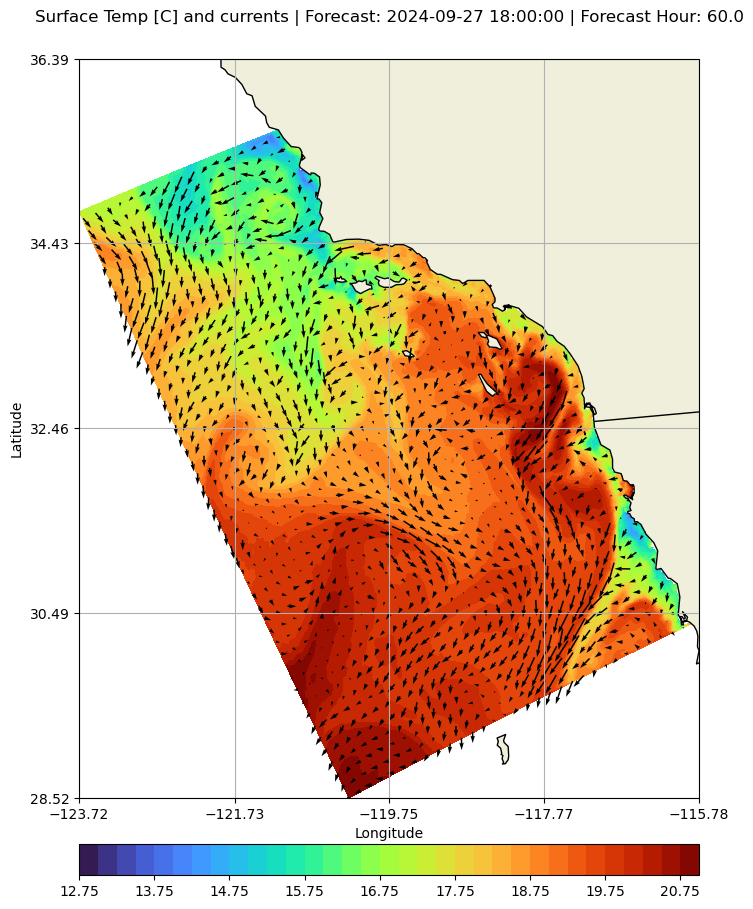

In [5]:
print('driver_run_forecast_LV1:  now make .in and .sb files...')
pfm_driver_src_dir = os.getcwd()
yyyymmdd = PFM['yyyymmdd']
hhmm = PFM['hhmm']
os.chdir('../sdpm_py_util')
make_LV1_dotin_and_SLURM( PFM , yyyymmdd + hhmm )
print('...done.\n')

# run command will be
print('now running roms with slurm...')
t01 = datetime.now()
run_slurm_LV1(PFM)
print('...done.')
os.chdir('../driver')
t02 = datetime.now()
print('this took:')
print(t02-t01)
print('\n')

# now making history file plots
print('now making LV1 history file plots...')
t01 = datetime.now()
pltfuns.make_all_his_figures('LV1')
print('...done.')
t02 = datetime.now()
print('this took:')
print(t02-t01)
print('\n')


In [ ]:



yyyymmdd='20240922'
yyyy = yyyymmdd[0:4]
mm = yyyymmdd[4:6]
dd = yyyymmdd[6:8]
dstr0 = yyyy + '-' + mm + '-' + dd + 'T12:00' # this is the forecast time

t1 =  datetime.strptime(dstr0,"%Y-%m-%dT%H:%M")
t2 = t1 + 8.0 * timedelta(days=1)
times = [t1,t2]
n0, num_missing = ocnfuns.check_hycom_data(yyyymmdd,times)

print('there should be')
print(str(n0))
print('files.')
print('The number of missing files is:')
print(str(num_missing))
print('(0 means we have all files we checked for)')



In [16]:
import glob
hycom_dir = '/scratch/PFM_Simulations/hycom_data/'
fns = glob.glob(hycom_dir + '*.nc')

#print(fns)
#print(fns[0])
fns3 = []
for fns2 in fns:
    #print(fns2[43:53])
    fns3.append(fns2[43:53])

#print(fns3)
set_res = set(fns3)
list_res = list(set_res)
list_res2 = sorted(list_res)
print(list_res2)

['2024-09-12', '2024-09-13', '2024-09-14', '2024-09-15', '2024-09-16', '2024-09-17', '2024-09-21', '2024-09-22']


In [ ]:
# this function removes all unneeded hycom forecasts. Only keeps the latest forecast with 8 days of data
# ie. clean_hycom_dir leave ONLY the hycom forecast that will be used in PFM
ocnfuns.clean_hycom_dir()
ocnfuns.refresh_hycom_dir()


In [4]:

ocnfuns.clean_hycom_dir()
hy_dates = ocnfuns.stored_hycom_dates()
fn_miss_list = ocnfuns.get_missing_file_num_list(hy_dates)

print(hy_dates)
print(fn_miss_list)


the date 2024-09-21 will not be deleted
the date 2024-09-22 will be deleted
['/scratch/PFM_Simulations/hycom_data/hy_t3z_2024-09-22T12:00_2024-09-23T15:00.nc', '/scratch/PFM_Simulations/hycom_data/hy_t3z_2024-09-22T12:00_2024-09-24T18:00.nc', '/scratch/PFM_Simulations/hycom_data/hy_s3z_2024-09-22T12:00_2024-09-28T03:00.nc', '/scratch/PFM_Simulations/hycom_data/hy_v3z_2024-09-22T12:00_2024-09-25T00:00.nc', '/scratch/PFM_Simulations/hycom_data/hy_t3z_2024-09-22T12:00_2024-09-22T21:00.nc', '/scratch/PFM_Simulations/hycom_data/hy_u3z_2024-09-22T12:00_2024-09-26T06:00.nc', '/scratch/PFM_Simulations/hycom_data/hy_t3z_2024-09-22T12:00_2024-09-24T03:00.nc', '/scratch/PFM_Simulations/hycom_data/hy_s3z_2024-09-22T12:00_2024-09-22T18:00.nc', '/scratch/PFM_Simulations/hycom_data/hy_s3z_2024-09-22T12:00_2024-09-27T12:00.nc', '/scratch/PFM_Simulations/hycom_data/hy_v3z_2024-09-22T12:00_2024-09-26T12:00.nc', '/scratch/PFM_Simulations/hycom_data/hy_u3z_2024-09-22T12:00_2024-09-25T06:00.nc', '/scratch/

In [ ]:

t0s = ocnfuns.stored_hycom_dates()
dstr0 = t0s[0] + 'T12:00' # this is the forecast time
t0 =  datetime.strptime(dstr0,"%Y-%m-%dT%H:%M")
tnow = datetime.now()
tget = []
while t0<tnow - timedelta(days=1):
    t0 = t0 + timedelta(days=1)
    yyyymmdd = "%d%02d%02d" % (t0.year, t0.month, t0.day)
    tget.append(yyyymmdd)

print('we will download, hopefully, the hycom with these forecast dates:')
print(tget)
for tt in tget:
    print('downloading hycom ' + tt + ' forecast')
    



In [ ]:

import glob
hycom_dir = '/scratch/PFM_Simulations/hycom_data/'

hy_dates = ocnfuns.stored_hycom_dates()
fn_miss_list = ocnfuns.get_missing_file_num_list(hy_dates)



print(len(hy_dates))
print(fn_miss_list)
fn2 = np.array(fn_miss_list)
ind0 = np.where(fn2 == 0)[0]
print(ind0)
keeper = np.max(ind0)

cnt = 0
for dt in hy_dates:
    if cnt != keeper:
        print('the date ' + dt + ' will be deleted')
        fnsd = hycom_dir + '*' + dt + 'T12:00_2*.nc'
        fls2d = glob.glob(fnsd)
        print(fls2d)
        print('will be deleted')
    else:
        print('the date ' + dt + ' will not be deleted')
    cnt=cnt+1

